# Transformer 

## Overview

A transformer is a sequence-to-sequence model that was initially introduced in the paper, 'Attention Is All You Need' (https://arxiv.org/abs/1706.03762). Essentially, transformers are used to map one sequence to another -- for example, translating one language (English) to another language (Norwegian). Sequence-to-sequence models are typically made up of two main components an 'encoder' and a 'decoder'. The encoder is used to understand and summarise the input sequence into some informative representation. The decoder can then carry out a predictive task whilst being conditioned on the information encoded by the representation of the input sequence.

Previously, in sequence-to-sequence models, the encoder and decoder were constructed using recurrent neural networks (RNNs). This is ideal, as RNNs learn representations whilst taking into account sequence dependencies. One of the major issues with this approach is that the input sequence is encoded into a single vector representation. This means information at the beginning of the sequences are often forgotten, which results in less informed predictions by the decoder. An approach to help solve this issue is to add an attention-mechanism. An attention-mechanism allows the decoder to focus on specific parts of the input sequence by assigning a weighting to each token in the sequence depending on how 'relevant' it is to the current representation in the decoder. This significantly improves the performance of sequence-to-sequence models. 

Using RNNs for the encoder and decoder results in a number of difficulties. First of all, RNNs are sequential models. Sequential models must wait until the previous operation is complete before continuing, therefore they have limited parallelisation and act as a computational bottleneck. Secondly, RNNs (LSTMs & GRUs) are prone to forgetting when the sequences are too long due to vanishing gradients. 

The transformer tackles these issues by learning informative representations through using self-attention alone and without the use of recurrent neural networks. These representations are then incorporated into the decoder by using a cross-attention mechanism. As such, the transformer has more space for parallelisation and can deal with longer sequences without suffering as much from vanishing gradients.


## Model
 ![transformer_diagram.png](../data/transformer_diagram.png)

The transformer model can be broken down into a series of block operations.

- Embedding layer
- Positional encoding layer
- Encoder
    - Encoder Blocks
        - Multi-head Attention
        - Add & Norm Layer
        - Feed-forward Neural Network
        - Add & Norm Layer
- Decoder
    - Decoder Blocks
        - Masked Multi-head Attention
        - Add & Norm Layer
        - Multi-head Attention
        - Add & Norm Layer
        - Feed-forward Neural Network
        - Add & Norm Layer
- Linear Softmax
        

### Embedding Layer
As with most tasks that deal with high-level data such as words in a sentence, the words have to be converted into a informative representation that can be inputted into a neural model. This is typically done by using an embedding layer which converts a word into a semantic vector representation. For example, a popular choice of embedding layer are Word2Vec embeddings, which gives each word a vector representation that depends on the surrounding context of the word. Words that show up in similar contexts will have similar vector representations.

### Positional Encoding Layer
Since we are dealing with sequential data, there exists an inherent ordering which needs to be incorporated into the encoded representation in order for the decoder to learn anything meaningful. When using an RNN, this positional information is implicitly accounted for in the encoded representation. This is not true when encoding a representation using attention alone. As a way to incorporate sentence ordering, the author's added a 'positional encoding layer' which assigns each token (and embedding dimension) a relative positioning using sinusoidal functions. 

For each position in a sentence and for each embedding dimension, the follow positional encodings are assigned:

$$
    \text{PE}_{(\text{pos}, 2i)} = \sin\bigg(\frac{\text{pos}}{10000^{\frac{2i}{d_{\text{model}}}}}\bigg)
$$

$$
    \text{PE}_{(\text{pos}, 2i+1)} = \cos\bigg(\frac{\text{pos}}{10000^{\frac{2i}{d_{\text{model}}}}}\bigg)
$$

### Attention
An attention mechanism is a function that takes in three inputs (query, key, value) and maps these to an output that measures how much each input key is 'interacts' with the query, weighted by the values. 

For example, given an English sentence (I don't like dogs) and the corresponding Norwegian sentences (Jeg liker ikke hunder), we can calculate the attention between the tokens in the Norwegian sentence and the tokens English sentence by formulating them as the following inputs: 

    Key: 'I don't like dogs'
    Query: 'Jeg liker ikke hunder'
    Value: 'I don't like dogs'

A similarity between each token in the keys and each token in the queries are calculated. A simple similarity function would be to take the scaled dot-product between the keys and queries. 

$$ScaledDot(Q, K) = \frac{QK^{T}}{\sqrt{d_k}} = [\text{I}, \text{dont}, \text{like}, \text{dogs}] \cdot [\text{Jeg}, \text{liker}, \text{ikke}, \text{hunder}]^T$$

This will produce a matrix containing the similarity between each of the English tokens with each of Norwegian tokens. 

You can imagine that the query token "ikke" will be most similar to the key token "don't". 

These similarities are then passed through a Softmax function and then used as weights to the input tokens to assign how important each input token is given the specific output token.

$$Attention(Q, K, V) = \text{Softmax} \bigg( \frac{QK^T}{\sqrt{d_k}}\bigg) V$$

### Multi-head Attention
Multi-head attention is a slight adaptation to the above explanation. Instead of having a single attention mechanism, resulting in a single attention representation, a multi-head attention mechanism first transforms the keys, queries, and values. 

This is done by linearly projecting the keys, queries, and values into a number of different representations. The attention is then calculated in this new representation, known as a 'head'. 

$$\text{Head}_i = \text{Attention} (QW_i^{Q}, KW_i^{K}, VW_i^{V})$$

where i can be any number of different heads.

All the heads are then concatenated and linearly projected. This represents the attention weights.

Empirically, it has been found that multi-head attention works better than a single-head attention mechanism. The paper, "Attention Is All You Need" explains this as the following: “multi-head attention allows the model to jointly attend to information from different representation subspaces at different positions”.


### Encoder Block
The encoder of the transformer can be broken down into a series of 'blocks'. These blocks contain the following operations (layers): 
    - Multi-head Attention
    - Add & Norm Layer
    - Feed-forward Neural Network
    - Add & Norm Layer

The multi-head attention is used to perform self-attention of the input sequence. This means that the keys, queries, and values are equal. Consequently, this results in a representation for each input token describing how it related to every other token in the input sequence. 

Each token is then separately passed through a feed-forward neural network to introduce non-linearity. Residual connections are used to preserve information from previous layers.

### Decoder Block
Similarity to the encoder, the decoder can be broken down into a series 'blocks'. These blocks contain the following operations (layers):
    - Masked Multi-head Attention
    - Add & Norm Layer
    - Multi-head Attention
    - Add & Norm Layer
    - Feed-forward Neural Network
    - Add & Norm Layer

The first multi-head attention mechanism is used to build a representation of the target sentences using self-attention. When the attention is calculated for each token, the subsequent tokens are 'masked' as to prevent information that is going to be predicted already being known to the decoder. 

The second multi-head attention is used to calculate the attention between the encoder output representation and the decoder representation. 

The output is then passed into the position-wise feed-forward network to introduce more non-linearity.

### Softmax Linear
The output of the decoder is then passed through a linear transformation and then a softmax function to make predictions.





## Translator
The Transformer can be used to map one language to another. In this example, a transformer was trained to map English sentences to Norwegian sentences. 

### Load in Language model + pre-trained Transformer translator

In [65]:
import pickle as pkl
import numpy as np
from utility import retrieve_data, filter_pad_sentences, train_test_sentences, convert_sentences_index
from language import Language
from translator import Translator

In [66]:
np.random.seed(0)

# Load in Training and Test data (& language models)
with open('../data/drive-download-20190919T220536Z-001/data_dict', 'rb') as f:
    data_dict = pkl.load(f)

english_language = data_dict['english_language']
norwegian_language  = data_dict['norwegian_language']
english_sentences_test = data_dict['english_test']
norwegian_sentences_test = data_dict['norwegian_test']

# Vocabulary size of English and Norwegian
english_vocab_size = english_language.vocab_size()
norwegian_vocab_size = norwegian_language.vocab_size()

print("English Vocab: %d" % english_vocab_size)
print("Norwegian Vocab: %d" % norwegian_vocab_size)

file_load_name = '../data/drive-download-20190919T220536Z-001/translator_model_transformer_7500.py'

English Vocab: 7503
Norwegian Vocab: 7501


In [67]:
# Instantiate Translator
translator = Translator(english_language, norwegian_language, cuda='cpu')

# Load in trained Transformer model
translator.load_model(file_load_name)

/Users/LiamEloie/Documents/Codes/Machine_Learning/supervised/norwegian_translator_transformer/api/translator.py:34: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(p)


In [68]:
# Load in training metrics
with open('../data/drive-download-20190919T220536Z-001/train_dict', 'rb') as f:
    train_dict = pkl.load(f)
    
bleu1s = train_dict['bleu1s']
bleu2s = train_dict['bleu2s']
bleu3s= train_dict['bleu3s']
bleu4s = train_dict['bleu4s']
train_losses = train_dict['train_losses']
test_losses = train_dict['test_losses']

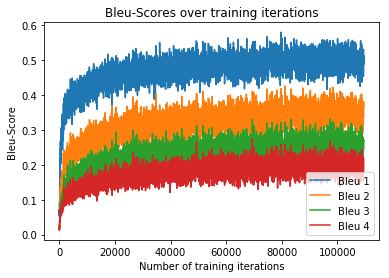

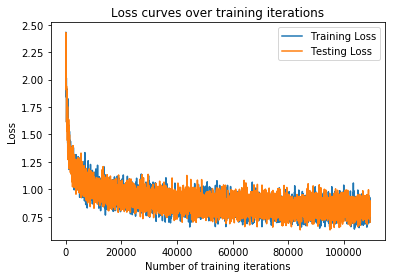

In [69]:
%matplotlib inline
import matplotlib.pyplot as plt

x_range = range(len(train_losses[10:]))
x_range = [x * 20 for x in x_range]

plt.plot(x_range, bleu1s[10:], label='Bleu 1')
plt.plot(x_range, bleu2s[10:], label='Bleu 2')
plt.plot(x_range, bleu3s[10:], label='Bleu 3')
plt.plot(x_range, bleu4s[10:], label='Bleu 4')

plt.xlabel('Number of training iterations')
plt.ylabel('Bleu-Score')
plt.title('Bleu-Scores over training iterations')
plt.legend()
plt.show()

plt.plot(x_range, train_losses[10:], label='Training Loss')
plt.plot(x_range, test_losses[10:], label='Testing Loss')
plt.xlabel('Number of training iterations')
plt.ylabel('Loss')
plt.title('Loss curves over training iterations')
plt.legend()
plt.show()


In [90]:
test_sentences = ['i like your house', 'the dog is green', 'where are you', 'can i have a coffee']

for sentence in test_sentences:
    translation = translator.translate(sentence, beam_n=1)
    print('%s ---> %s' % (sentence, translation))

i like your house ---> jeg liker huset ditt
the dog is green ---> hunden er grønn
where are you ---> hvor er du
can i have a coffee ---> kan jeg få en kaffe
